In [1]:
%env CC=gcc-11
%env CXX=g++-11

env: CC=gcc-11
env: CXX=g++-11


In [55]:
DATASET_NAME="pick_miss_cup_autoencoder"

## Intorduction

As in data analysis we first need to load the data and perform all the normalization and optimizations. The normalized data after all will be passed through encoder part of trained autoencoder just to get only relavent features in the data. 

So let's start with data loading:

##### Normal data

In [3]:
import pandas

DATA = pandas.read_csv('../../../robot-data/new_data/normal/merged_normal_pick.csv')
DATA

,Counter(/arm_trajectory_controller/follow_joint_trajectory/status),/arm_trajectory_controller/follow_joint_trajectory/status My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Var_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Counter(/arm_trajectory_controller/state),/arm_trajectory_controller/state My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/state),Counter(/battery),/battery My_Traffic(Bytes),Counter(/detected_objects),...,shoulder2_joint position,torso_joint position,left_wheel_joint effort,right_finger_joint effort,right_wheel_joint effort,rotation1_joint effort,torso_joint effort,wrist_joint effort,head_tilt_joint velocity,left_wheel_joint velocity
0,4,284,0.264902,1.264027e-02,12,6456,0.071533,0,0,0,...,2.183829,0.301,0.0,-0.02690,0.0,-0.064453,92.853043,0.032227,0.0,0.0
1,5,355,0.200013,4.539819e-05,14,7532,0.069651,1,93,0,...,2.183829,0.301,0.0,-0.02421,0.0,-0.080566,82.853053,0.008057,0.0,0.0
2,5,355,0.201024,3.146104e-06,12,6456,0.087292,0,0,0,...,2.183829,0.298,0.0,-0.02421,0.0,0.000000,88.853035,0.052368,0.0,0.0
3,5,355,0.200395,2.509922e-06,11,5918,0.086181,1,93,0,...,2.183829,0.303,0.0,-0.02421,0.0,0.000000,104.853008,0.032227,0.0,0.0
4,5,355,0.200118,1.580059e-06,13,6994,0.081231,0,0,1,...,2.183829,0.299,0.0,-0.02690,0.0,-0.112793,90.853009,0.008057,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671,5,610,0.200005,3.723324e-07,15,8070,0.067330,0,0,1,...,2.183880,0.277,0.0,0.46268,0.0,0.000000,-85.098008,0.056396,0.0,0.0
1672,5,610,0.200002,2.663688e-08,15,8070,0.066322,1,93,2,...,2.183880,0.272,0.0,0.45999,0.0,0.000000,-78.543533,0.060425,0.0,0.0
1673,5,610,0.199537,8.526598e-07,15,8070,0.068983,0,0,1,...,2.183880,0.268,0.0,0.45999,0.0,0.048340,-75.750176,0.060425,0.0,0.0
1674,5,610,0.198214,1.329264e-05,15,8070,0.066772,1,93,1,...,2.183880,0.263,0.0,0.45999,0.0,0.000000,-72.689521,0.060425,0.0,0.0


##### Anomaly data

In [4]:
ANOMALY_DATA = pandas.read_csv('../../../robot-data/new_data/test/merged_pick_miss_cup.csv')
ANOMALY_DATA

,Counter(/arm_trajectory_controller/follow_joint_trajectory/status),/arm_trajectory_controller/follow_joint_trajectory/status My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Var_Consecutive(/arm_trajectory_controller/follow_joint_trajectory/status),Counter(/arm_trajectory_controller/state),/arm_trajectory_controller/state My_Traffic(Bytes),Mean_Consecutive(/arm_trajectory_controller/state),Counter(/battery),/battery My_Traffic(Bytes),Counter(/detected_objects),...,left_wheel_joint effort,right_wheel_joint effort,rotation1_joint effort,torso_joint effort,wrist_joint effort,head_tilt_joint velocity,left_wheel_joint velocity,right_wheel_joint velocity,shoulder1_joint velocity,shoulder2_joint velocity
0,6,120,0.190663,1.291337e-02,12,6456,0.063092,0,0,0,...,0.0,0.0,0.000000,-7.569872,0.000000,0.0,0.0,0.0,0.000000,0.0
1,5,100,0.199080,3.438309e-06,15,8070,0.065023,0,0,0,...,0.0,0.0,0.000000,-1.429256,0.008057,0.0,0.0,0.0,0.000000,0.0
2,5,100,0.200019,1.036475e-05,16,8608,0.064299,1,93,0,...,0.0,0.0,0.000000,-7.379467,0.000000,0.0,0.0,0.0,0.000000,0.0
3,5,100,0.199980,1.747321e-05,14,7532,0.070981,0,0,0,...,0.0,0.0,0.000000,-1.260519,0.008057,0.0,0.0,0.0,0.000000,0.0
4,5,100,0.200011,4.932453e-08,15,8070,0.064694,1,93,0,...,0.0,0.0,0.000000,-3.198487,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,5,360,0.199993,1.427605e-08,15,8070,0.068399,0,0,1,...,0.0,0.0,-0.064453,-81.999998,0.056396,0.0,0.0,0.0,0.000000,0.0
1686,5,360,0.199986,9.456916e-08,14,7532,0.069274,1,93,0,...,0.0,0.0,-0.128906,-87.999980,0.056396,0.0,0.0,0.0,0.000000,0.0
1687,5,360,0.199958,1.688842e-08,14,7532,0.074080,0,0,0,...,0.0,0.0,-0.064453,-82.051771,0.056396,0.0,0.0,0.0,0.000000,0.0
1688,5,360,0.199994,1.212901e-06,14,7532,0.067554,1,93,1,...,0.0,0.0,-0.048340,-91.781406,0.056396,0.0,0.0,0.0,0.000209,0.0


For normalization we choose `MinMaxScaler` with value range between $\left[1, -1\right]$

In [24]:
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import norm
import numpy as np
import heapq
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
from sklearn.decomposition import PCA
import datetime
from IPython.display import Image
import math
import pickle

## Data processing

#### Data processing utils

In [6]:
scalers = {}

def normalize_data(original_data):
    """
    This function used for normalizing data, with MinMaxScaler.
    Each scaler saved in the external object for future use of de-transformation
    :param original_data: data from the file
    :return: normlized data in the same format as received
    """
    norm_data = original_data
    for i in original_data.columns:
        scaler = None
        if ('scaler_' + i) not in scalers:
            scaler = MinMaxScaler(feature_range=(-1, 1))
        else:
            scaler = scalers['scaler_' + i]
        s_s = scaler.fit_transform(norm_data[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        norm_data[i] = s_s
    return norm_data

def std_normalize_data(data):
    """
    This function used for normalizing data, with StandardScaler.
    Each scaler saved in the external object for future use of de-transformation
    :param original_data: data from the file
    :return: normlized data in the same format as received
    """
    norm_data = data
    for i in data.columns:
        scaler = None
        if ('scaler_' + i) not in scalers:
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            scaler = scalers['scaler_' + i]
        s_s = scaler.fit_transform(norm_data[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        norm_data[i] = s_s
    return norm_data

def unnormalize_data(columns, reconstructed_data):
    """
    This function is normalization inverse function.
    :param columns: orinal columns names, used for taking correct scaler that was saved while normalization
    :param reconstructed_data: normalized data
    :return: unnormalized data 
    """
    restored_data = []
    for (i, name) in enumerate(columns):
        restored_data.append(np.array(scalers['scaler_' + name].inverse_transform(reconstructed_data[:,i].reshape(-1, 1))).flatten())
    return np.array(restored_data)

def draw_from_GMM(mus, sigmas, thetas, numOfDraws = 1):
    """
    This function draws samples based on mu, sigma and theta of Gaussian Mixture Model
    :param mus: list of mus
    :param sigmas: list of sigmas
    :param thetas: list of thetas
    :param numOfDraws: number of draws from distribution
    :return: list of samples and list of lists of samples
    """
    gmm_res = []
    gaussians = []
    for j in range(len(thetas[0])):
        gaussians.append([])
    for i in tqdm(range(len(mus))):
        mixture_idx = np.random.choice(len(thetas[i]), size=1, replace=True, p=thetas[i])[0]
        samples = np.random.normal(mus[i,mixture_idx], sigmas[i,mixture_idx], size=numOfDraws)
        sample_index = np.random.choice(len(samples), size=1, replace=True)[0]
        gmm_res.append(samples[sample_index]) 
        gaussians[mixture_idx].append(samples[sample_index])
    return gmm_res, gaussians

def calc_lppd(mus, sigmas, thetas, y):
    ppd_res = 0
    lppds = []
    for n in tqdm(range(len(y))):
        ppd_res = 0
        for i in range(len(mus)):
            mixture_idx = np.random.choice(len(thetas[i]), size=1, replace=True, p=thetas[i])[0]
            ppd_res += norm.pdf(y[n], mus[i, mixture_idx], sigmas[i, mixture_idx])
        lppds.append(math.log(ppd_res/len(mus))) 
        
    return lppds, np.sum(lppds)

def calc_lppd_vec(mus, sigmas, thetas, y):
    ppd_res = 0
    lppds = []
    for n in range(len(y)):
        ppd_res = 0
        pdf = norm.pdf(y[n], mus, sigmas)
        ppd_res = np.sum(np.multiply(thetas, pdf))
        lppds.append(math.log(ppd_res/len(mus)))
    return lppds, np.sum(lppds)

def calc_lppd_vec_sliding_window(mu, sigma, theta, y, window_size=5):
    windows = np.lib.stride_tricks.sliding_window_view(y, window_size)
    wlppd = []
    for w in windows:
        lppds, lppd = calc_lppd_vec(mu, sigma, theta, w)
        wlppd.append(np.average(lppds))
    return wlppd, np.sum(wlppd)


    """
    Data split for train and labels with sliding window
    :param data: original data
    :param window: subsequence length
    :return:
    """
    train_x = data[:window + 1]
    x, y = sliding_windows(train_x, 1)
    train_x = Variable(torch.Tensor(np.array(x)))
    train_y = Variable(torch.Tensor(np.array(y)))
    return train_x, train_y


def sliding_windows(data, seq_length):
    """
    Sliding window transformation for the data
    :param data: original data
    :param seq_length: window size
    :return: two arrays of x and y
    """
    x = []
    y = []
    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)



#### Train Autoencoder

In [17]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
seq_len = 300
reduced_features = 2

def train_autoencoder(data, layer_size=128):
    encoder = None
    if os.path.isdir('./stan/encoder_model.ml'):
        encoder = keras.models.load_model('./stan/encoder_model.ml')
    else:
        input_data = Input(shape=(data.shape[1],))
        encoded1 = Dense(layer_size, activation='relu')(input_data)
        encoded2 = Dense(reduced_features, activation='relu')(encoded1)
        decoded1 = Dense(layer_size, activation='relu')(encoded2)
        decoded2 = Dense(data.shape[1], activation=None)(decoded1)
        autoencoder = Model(input_data, decoded2)
        autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
        autoencoder.summary()
        autoencoder.fit(data, data,
                        epochs=500,
                        batch_size=16,
                        shuffle=True)
        encoder = Model(input_data, encoded2)
        encoder.save('./stan/encoder_model.ml')
    return encoder

##### Choosing common columns

While looking on the data we saw that there are small difference in the columns of anomaly and normal data, so we tried to find common columns.

In [68]:
norm_data, columns = normalize_data(DATA.copy()).values, list(DATA.columns.values)

columns = DATA.columns
anomaly_columns = ANOMALY_DATA.columns
common_columns = np.intersect1d(columns, anomaly_columns)
common_columns = [x for _, x in sorted(zip(columns, common_columns), key=lambda pair: pair[0])]
anomaly_norm_data = normalize_data(ANOMALY_DATA.copy())[common_columns].values
print("Common columns:", anomaly_norm_data.shape)
norm_data = normalize_data(DATA[common_columns].copy())
print('Original dataset shape:', norm_data.shape)

Common columns: (1690, 249)
Original dataset shape: (1676, 249)


In [19]:
encoder = train_autoencoder(norm_data, norm_data.shape[1])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 249)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 249)               62250     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 500       
_________________________________________________________________
dense_7 (Dense)              (None, 249)               747       
_________________________________________________________________
dense_8 (Dense)              (None, 249)               62250     
Total params: 125,747
Trainable params: 125,747
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1676/1676 [==============================] - 0s 144us/step - loss: 0.1804
Epoch 2/500
1676/1676 [==========

1676/1676 [==============================] - 0s 85us/step - loss: 0.0730
Epoch 85/500
1676/1676 [==============================] - 0s 77us/step - loss: 0.0728
Epoch 86/500
1676/1676 [==============================] - 0s 82us/step - loss: 0.0726
Epoch 87/500
1676/1676 [==============================] - 0s 82us/step - loss: 0.0726
Epoch 88/500
1676/1676 [==============================] - 0s 66us/step - loss: 0.0724
Epoch 89/500
1676/1676 [==============================] - 0s 77us/step - loss: 0.0722
Epoch 90/500
1676/1676 [==============================] - 0s 65us/step - loss: 0.0721
Epoch 91/500
1676/1676 [==============================] - 0s 76us/step - loss: 0.0721
Epoch 92/500
1676/1676 [==============================] - 0s 104us/step - loss: 0.0720
Epoch 93/500
1676/1676 [==============================] - 0s 78us/step - loss: 0.0718
Epoch 94/500
1676/1676 [==============================] - 0s 77us/step - loss: 0.0717
Epoch 95/500
1676/1676 [==============================] - 0s 86us/

1676/1676 [==============================] - 0s 92us/step - loss: 0.0680
Epoch 179/500
1676/1676 [==============================] - 0s 144us/step - loss: 0.0681
Epoch 180/500
1676/1676 [==============================] - 0s 75us/step - loss: 0.0678
Epoch 181/500
1676/1676 [==============================] - 0s 60us/step - loss: 0.0678
Epoch 182/500
1676/1676 [==============================] - 0s 109us/step - loss: 0.0678
Epoch 183/500
1676/1676 [==============================] - 0s 116us/step - loss: 0.0679
Epoch 184/500
1676/1676 [==============================] - 0s 104us/step - loss: 0.0677
Epoch 185/500
1676/1676 [==============================] - 0s 80us/step - loss: 0.0678
Epoch 186/500
1676/1676 [==============================] - 0s 83us/step - loss: 0.0676
Epoch 187/500
1676/1676 [==============================] - 0s 130us/step - loss: 0.0677
Epoch 188/500
1676/1676 [==============================] - 0s 113us/step - loss: 0.0677
Epoch 189/500
1676/1676 [==========================

1676/1676 [==============================] - 0s 79us/step - loss: 0.0659
Epoch 273/500
1676/1676 [==============================] - 0s 63us/step - loss: 0.0659
Epoch 274/500
1676/1676 [==============================] - 0s 76us/step - loss: 0.0659
Epoch 275/500
1676/1676 [==============================] - 0s 69us/step - loss: 0.0657
Epoch 276/500
1676/1676 [==============================] - 0s 75us/step - loss: 0.0661
Epoch 277/500
1676/1676 [==============================] - 0s 81us/step - loss: 0.0660
Epoch 278/500
1676/1676 [==============================] - 0s 59us/step - loss: 0.0657
Epoch 279/500
1676/1676 [==============================] - 0s 80us/step - loss: 0.0659
Epoch 280/500
1676/1676 [==============================] - 0s 66us/step - loss: 0.0658
Epoch 281/500
1676/1676 [==============================] - 0s 75us/step - loss: 0.0657
Epoch 282/500
1676/1676 [==============================] - 0s 72us/step - loss: 0.0658
Epoch 283/500
1676/1676 [==============================] 

1676/1676 [==============================] - 0s 56us/step - loss: 0.0642
Epoch 367/500
1676/1676 [==============================] - 0s 58us/step - loss: 0.0640
Epoch 368/500
1676/1676 [==============================] - 0s 56us/step - loss: 0.0640
Epoch 369/500
1676/1676 [==============================] - 0s 53us/step - loss: 0.0640
Epoch 370/500
1676/1676 [==============================] - 0s 63us/step - loss: 0.0640
Epoch 371/500
1676/1676 [==============================] - 0s 56us/step - loss: 0.0639
Epoch 372/500
1676/1676 [==============================] - 0s 55us/step - loss: 0.0639
Epoch 373/500
1676/1676 [==============================] - 0s 53us/step - loss: 0.0640
Epoch 374/500
1676/1676 [==============================] - 0s 58us/step - loss: 0.0639
Epoch 375/500
1676/1676 [==============================] - 0s 94us/step - loss: 0.0639
Epoch 376/500
1676/1676 [==============================] - 0s 70us/step - loss: 0.0639
Epoch 377/500
1676/1676 [==============================] 

1676/1676 [==============================] - 0s 54us/step - loss: 0.0626
Epoch 461/500
1676/1676 [==============================] - 0s 66us/step - loss: 0.0626
Epoch 462/500
1676/1676 [==============================] - 0s 56us/step - loss: 0.0625
Epoch 463/500
1676/1676 [==============================] - 0s 58us/step - loss: 0.0626
Epoch 464/500
1676/1676 [==============================] - 0s 53us/step - loss: 0.0626
Epoch 465/500
1676/1676 [==============================] - 0s 55us/step - loss: 0.0626
Epoch 466/500
1676/1676 [==============================] - 0s 53us/step - loss: 0.0626
Epoch 467/500
1676/1676 [==============================] - 0s 52us/step - loss: 0.0625
Epoch 468/500
1676/1676 [==============================] - 0s 56us/step - loss: 0.0625
Epoch 469/500
1676/1676 [==============================] - 0s 64us/step - loss: 0.0625
Epoch 470/500
1676/1676 [==============================] - 0s 58us/step - loss: 0.0626
Epoch 471/500
1676/1676 [==============================] 

In [20]:
new_data = encoder.predict(norm_data)
encoder.summary()
weights = encoder.get_weights()[1]
print(weights.shape, weights)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 249)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 249)               62250     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 500       
Total params: 62,750
Trainable params: 62,750
Non-trainable params: 0
_________________________________________________________________
(249,) [-0.00911011 -0.00506617 -0.00743999 -0.01031089  0.         -0.0019235
 -0.02326801 -0.04657866  0.00069033 -0.02634686  0.00543052  0.00058046
 -0.00199828 -0.02340443 -0.01515881 -0.00341624 -0.02516521  0.00163893
 -0.00529027 -0.00834055 -0.01787239 -0.01471544 -0.00121901  0.00135521
  0.00514767 -0.00076704 -0.00612089 -0.02305098 -0.03261594 -0.02480914
 -0.0049548  -

#### Taking most important weights

In [32]:
most_important = [[i, weights[i]] for i in heapq.nlargest(12, range(len(weights)), weights.__getitem__)]
most_important = sorted(most_important , key=lambda a_entry: -a_entry[1])
most_important_data_fragment = pandas.DataFrame(most_important, columns=['Index of column', 'PCA coefficient'])
most_important_data_fragment

,Index of column,PCA coefficient
0,144,0.056317
1,34,0.024350
2,172,0.023691
3,129,0.019866
4,88,0.017337
5,98,0.014156
6,165,0.013622
7,115,0.008743
8,117,0.008237
9,53,0.008049


In [35]:
initial_feature_names = DATA.columns
most_important_column_names = [initial_feature_names[most_important[i][0]] for i in range(len(most_important))]
most_important_column_names_df = pandas.DataFrame(most_important_column_names, columns=['Column name'])
pandas.set_option("max_colwidth", 700)
most_important_column_names_df

,Column name
0,Mean_Consecutive(/kinect2/sd/image_color_rect)
1,Counter(/find_object_node/hsv_filterd/compressedDepth/parameter_updates)
2,Counter(/mobile_base_controller/odom)
3,Mean_Consecutive(/kinect2/qhd/image_mono)
4,Counter(/kinect2/hd/image_depth_rect)
5,/kinect2/hd/image_mono/compressed My_Traffic(Bytes)
6,Mean_Consecutive(/kinect2/sd/image_ir/compressed)
7,Counter(/kinect2/qhd/image_color_rect)
8,Mean_Consecutive(/kinect2/qhd/image_color_rect)
9,/find_object_node/result/compressedDepth/parameter_descriptions My_Traffic(Bytes)


Density estimation
measure density of the data path (Deep density estimation)
simulation base inference

(1. PCA 2. To choose part of columns 3. Run pca again on chosen columns)
4. * Use autoencoder to reduce dimensions 
5. Read about dimensionality reduction
6. Map data to reduced dimentions
7. GMM with 2d
(PCA?) -> Autoencoder -> (normalizing flow for density estimation?) -> GMM-2D

134


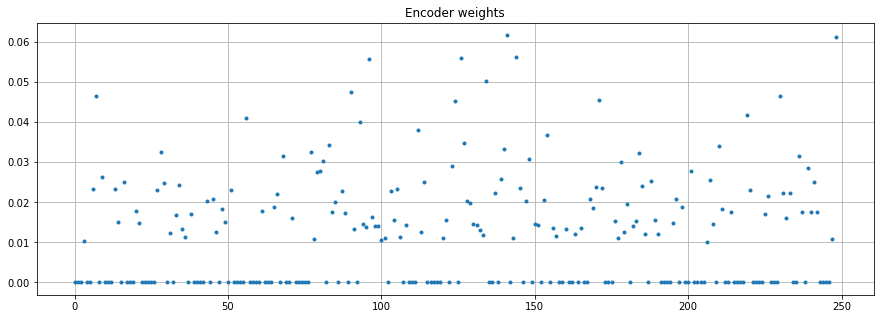

In [40]:
important_weights = np.where(abs(weights) <= 0.01, 0, weights)
print(np.count_nonzero(important_weights))
fig, axs = plt.subplots(1, figsize=(15, 5))
axs.plot(abs(important_weights.T), ".")
axs.set_title('Encoder weights')
plt.grid()
plt.show()
plt.close()

As the result of filtering we got only 12 points which mean that we have only 12 features of the original data will play major role in the linear transformation on the data we perform next.

(1676, 2)
(1690, 2)


Text(0.5, 1.0, 'Lineary transformed data')

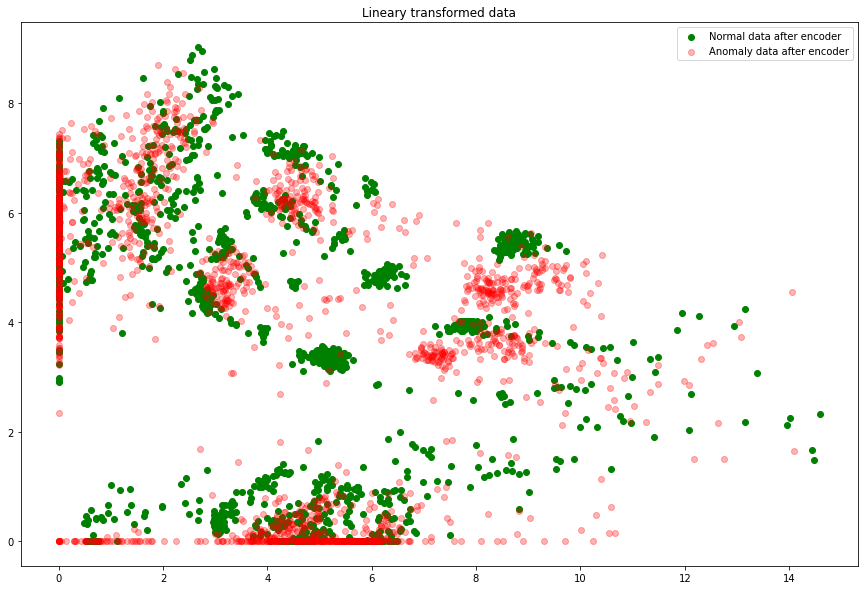

In [41]:
anomaly_encode = encoder.predict(anomaly_norm_data)
fig, axs = plt.subplots(1, figsize=(15, 10))
normal_encoded_data = new_data 
anomaly_encoded_data = anomaly_encode 
print(normal_encoded_data.shape)
print(anomaly_encoded_data.shape)
axs.scatter(normal_encoded_data[:,0], normal_encoded_data[:,1], color="g", label="Normal data after encoder")
axs.scatter(anomaly_encoded_data[:,0], anomaly_encoded_data[:,1], color="r", alpha=0.3, label="Anomaly data after encoder")
axs.legend()
axs.set_title('Lineary transformed data')

In [35]:
normal_encoded_data_df = pandas.DataFrame(normal_encoded_data, columns=['y1', 'y2'])
normal_encoded_data_df

,y1,y2
0,2.973262,-3.879711
1,-2.858649,-8.150966
2,-1.180230,-6.350606
3,-4.094069,-4.895358
4,-0.932764,-6.128677
...,...,...
1671,3.901709,-1.652867
1672,-0.931986,-5.475619
1673,-1.244238,-5.912041
1674,-1.058517,-5.555667


##### PCA Results plot 

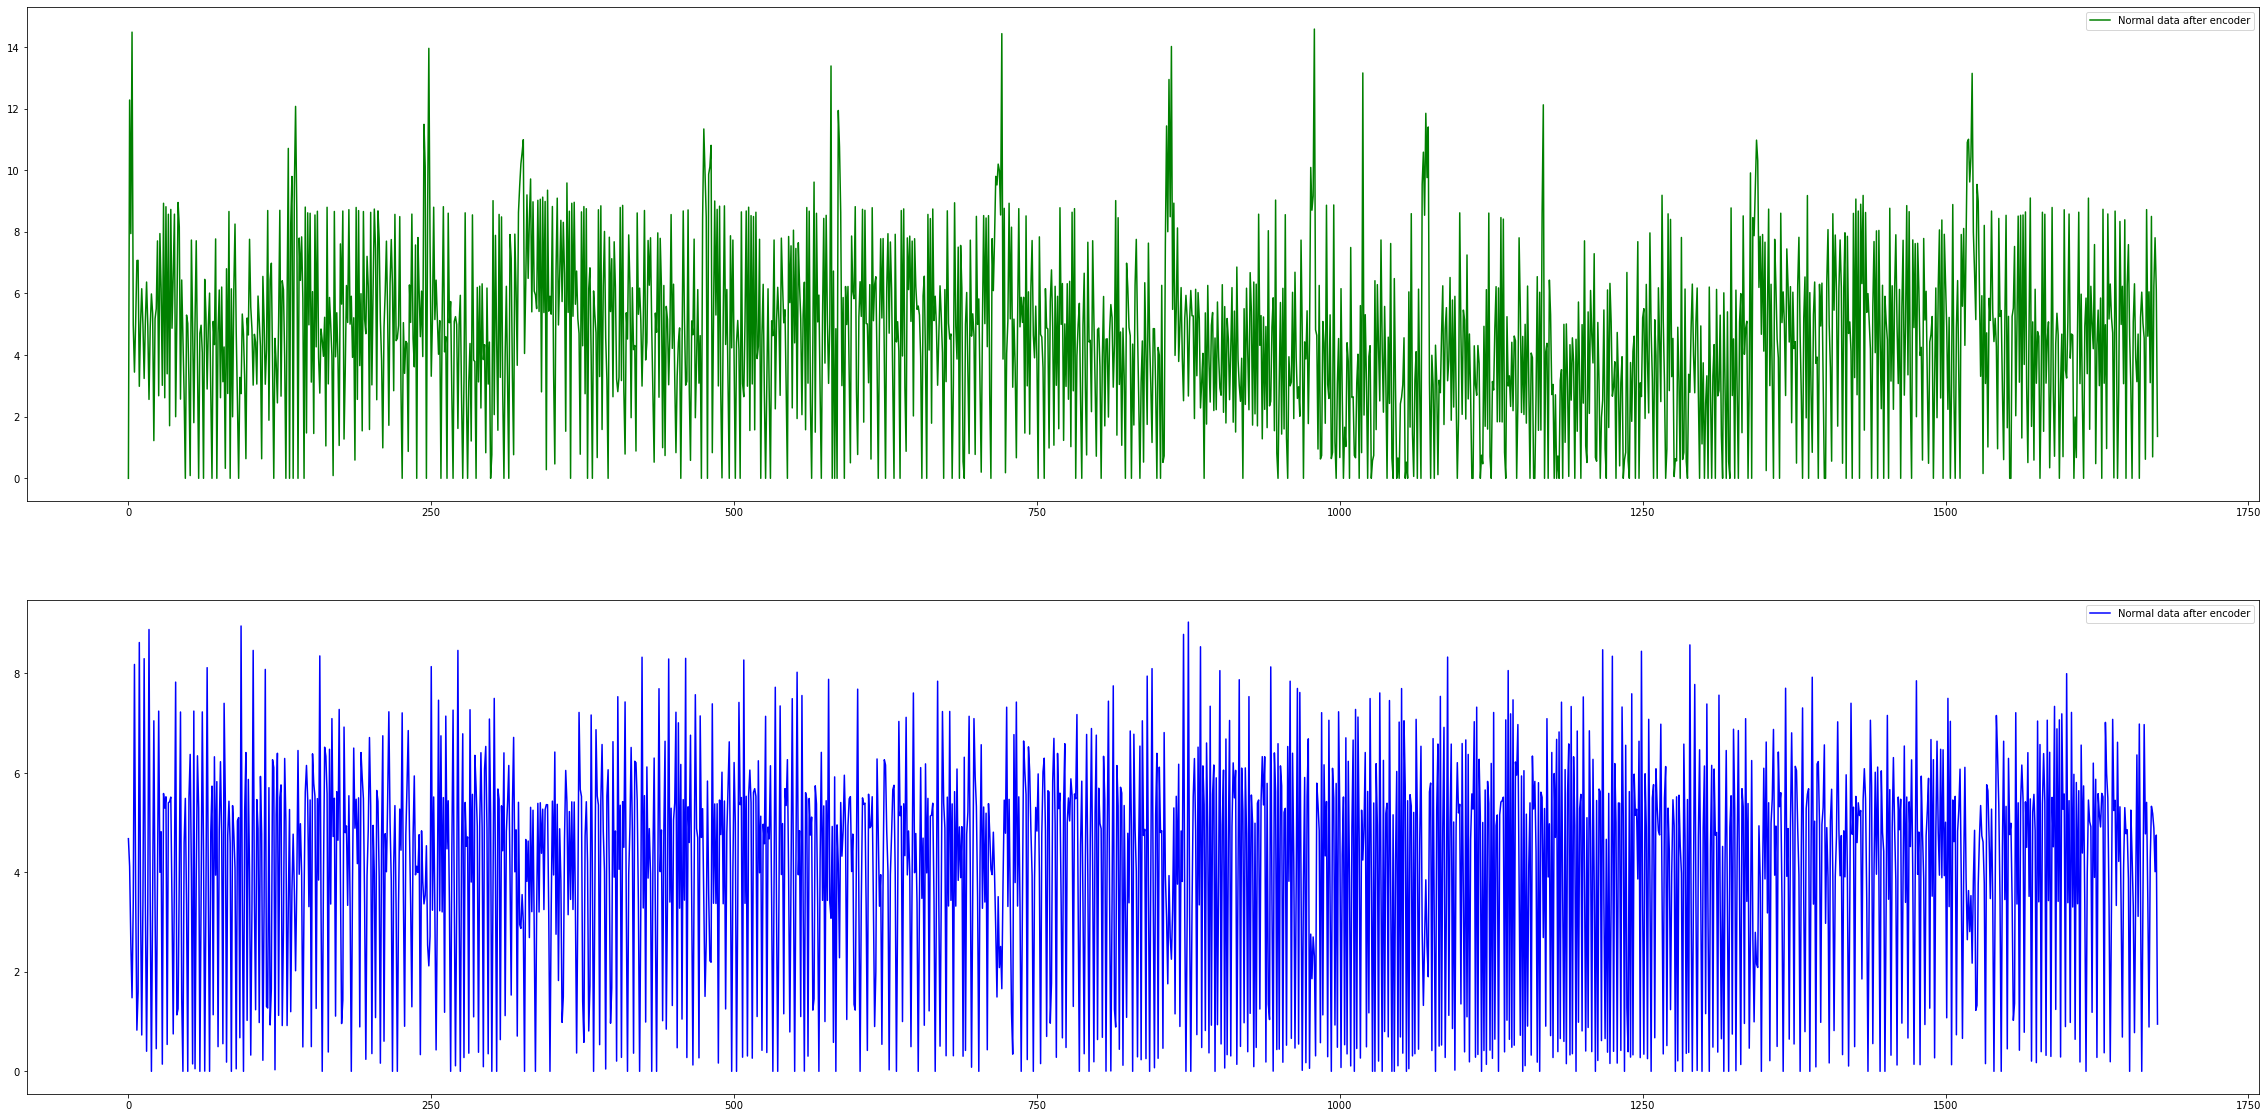

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(40, 20), squeeze=False)
axs[0][0].plot(range(len(normal_encoded_data[:,0])), normal_encoded_data[:,0], color="g", label="Normal data after encoder")
axs[1][0].plot(range(len(normal_encoded_data[:,1])), normal_encoded_data[:,1], color="b", label="Normal data after encoder")
axs[0][0].legend()
axs[1][0].legend()

Just to understand behaviour of the data we decided to plot histogram

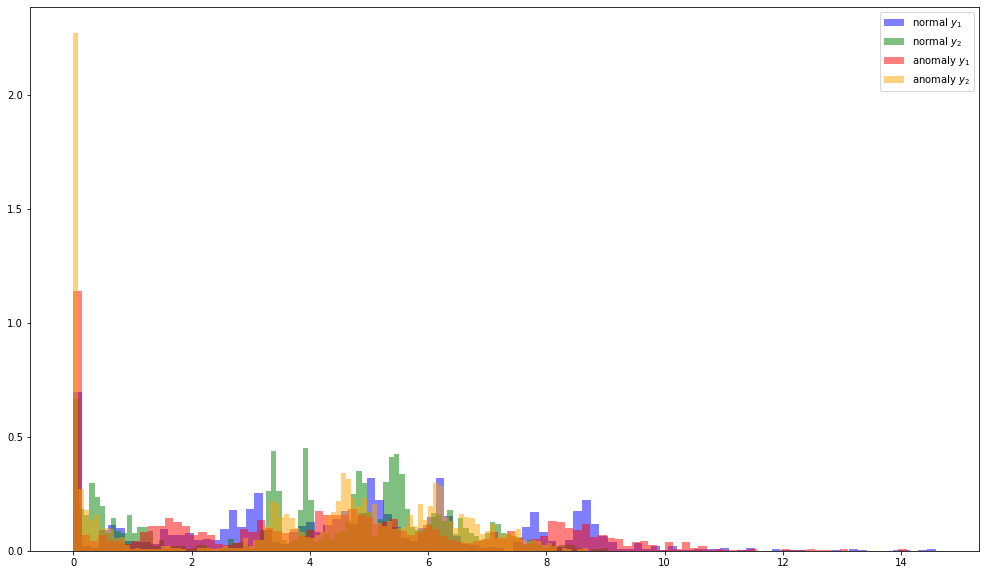

In [45]:
fig, axs = plt.subplots(1, figsize=(17, 10))
n, bins, patches = axs.hist(list(normal_encoded_data[:, 0]), 100, facecolor='b', alpha=0.5, density=True, stacked=True, label="normal $y_1$")
n, bins, patches = axs.hist(list(normal_encoded_data[:, 1]), 100, facecolor='g', alpha=0.5, density=True, stacked=True, label="normal $y_2$")
n, bins, patches = axs.hist(list(anomaly_encoded_data[:, 0]), 100, facecolor='r', alpha=0.5, density=True, stacked=True, label="anomaly $y_1$")
n, bins, patches = axs.hist(list(anomaly_encoded_data[:, 1]), 100, facecolor='orange', alpha=0.5, density=True, stacked=True, label="anomaly $y_2$")
axs.legend()

To see the results more clear we will normilize the data again to be in range between 0 and 1

## Model

Density estimation
DP-GMM or HDP



In [46]:
import pystan

In [47]:
GMM_MODEL = """
data {
    int<lower=0> N;            // Number of measurements
    vector[N] y;                 // Data
    
    int<lower=1> k;// Number of Gaussians

    real<lower=0> mu_loc_prior;
    real<lower=0> mu_shape_prior;
    real<lower=0> sigma_loc_prior;
    real<lower=0> sigma_shape_prior;

    real<lower=0> theta_loc_prior;
    real<lower=0> theta_scale_prior;
}
parameters {
    ordered[k] mu;
    real<lower=0> sigma[k];
    simplex[k] theta;
}
model {
    real ll[k];
    sigma ~ normal(sigma_loc_prior, sigma_shape_prior);
    mu ~ normal(mu_loc_prior, mu_shape_prior);
    theta ~ beta(theta_loc_prior, theta_scale_prior);
    
    for (n in 1:N) {
        for (i in 1:k) {
            ll[i] = log(theta[i]) + normal_lpdf(y[n] | mu[i], sigma[i]);
        }
        target += log_sum_exp(ll);
    }       
}
"""

In [48]:
model = None
if os.path.isfile('./stan/model.pkl'):
    model = pickle.load(open('./stan/model.pkl', 'rb'))
else:  
    model = pystan.StanModel(model_code=GMM_MODEL, verbose=False, extra_compile_args=["-w"])
    with open('./stan/model.pkl', 'wb') as f:
        pickle.dump(model, f)

##### Real data run

We will take only one dimension of our two dimensional dataset and try the model on it

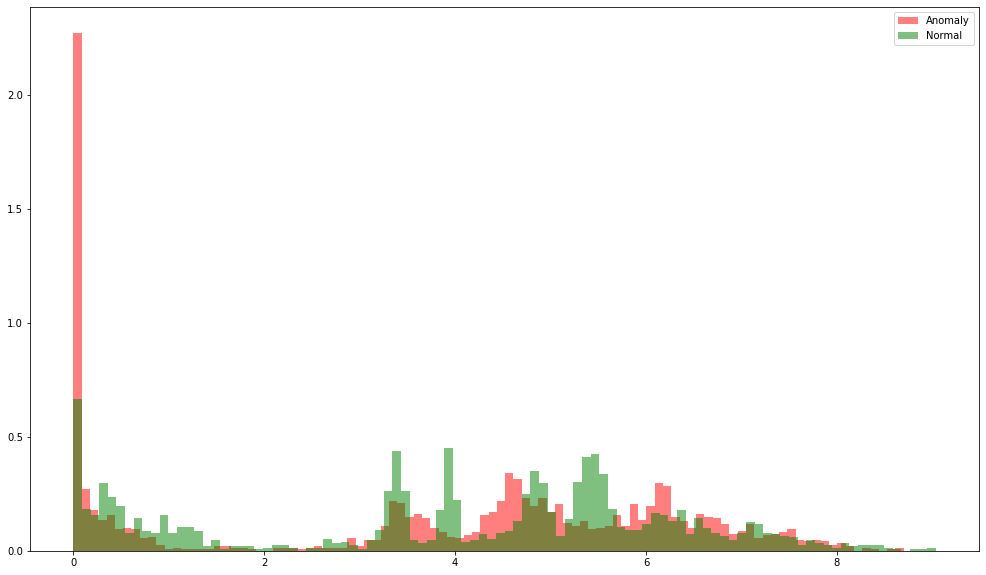

In [51]:
stan_normal_data = normal_encoded_data[:,1]
stan_anomaly_data = anomaly_encoded_data[:,1]
fig, axs = plt.subplots(1, figsize=(17, 10))
n, anomaly_bins, patches = axs.hist(stan_anomaly_data, 100, facecolor='r', alpha=0.5, density=True, stacked=True, label="Anomaly")
n, norm_bins, patches = axs.hist(stan_normal_data, 100, facecolor='g', alpha=0.5, density=True, stacked=True, label="Normal")
axs.legend()

In [53]:
def plot_simulations(simulations, snd, sad):
    fig, axs = plt.subplots(2, figsize=(17, 17))
    n, bins, patches = axs[0].hist(sad, 200, facecolor='r', alpha=0.5, density=True, stacked=True, label="anomaly")
    n, bins, patches = axs[0].hist(snd, 200, facecolor='g', alpha=0.5, density=True, stacked=True, label="normal")
    n, bins, patches = axs[0].hist(simulations, 200, facecolor='b', alpha=0.5, density=True, stacked=True, label="simulated")
    n, bins, patches = axs[1].hist(simulations, 200, facecolor='b', alpha=0.5, density=True, stacked=True, label="simulated")
    axs[0].legend()
    axs[1].legend()
    plt.show()
    
def plot_lppd(lppds):
    fig, axs = plt.subplots(2, figsize=(17, 17))
    n, bins, patches = axs[0].hist(lppds, 200, alpha=0.5, density=True, stacked=True, label="lppd")
    axs[1].plot(range(len(lppds)), lppds, label="lppd")
    axs[0].legend()
    axs[1].legend()
    plt.show()

def train_and_plot(num_of_gaussians, data, anomaly_data):
    mu_loc_prior = 0;
    mu_shape_prior = 2;
    sigma_loc_prior = 0.1;
    sigma_shape_prior = 2;
    theta_loc_prior = 5;
    theta_scale_prior = 5;
    print(data.shape)
    st_data= {
        'N':data.shape[0],
        'y':data,
        'k': num_of_gaussians,
        'mu_loc_prior': mu_loc_prior,
        'mu_shape_prior': mu_shape_prior,
        'sigma_loc_prior': sigma_loc_prior,
        'sigma_shape_prior': sigma_shape_prior,
        'theta_loc_prior': theta_loc_prior,
        'theta_scale_prior': theta_scale_prior
    }
    fit = None
    if os.path.isfile('./stan/fit_' + DATASET_NAME+ '_' + str(num_of_gaussians) + '.pkl'):
        fit = pickle.load(open('./stan/fit_' + DATASET_NAME + '_' + str(num_of_gaussians) + '.pkl', 'rb'))
    else:
        fit = model.sampling(data=st_data, iter=1000, verbose=False, n_jobs=-1)
        with open('./stan/fit_' + DATASET_NAME + '_' + str(num_of_gaussians) + '.pkl', 'wb') as g:
            pickle.dump(fit, g)
    
    print(fit)
    samples = fit.extract(permuted=True)
    mu = samples['mu']
    sigma = samples['sigma']
    theta = samples['theta']
    print(np.mean(mu, axis=0))
    print(np.mean(sigma, axis=0))
    print(np.mean(theta, axis=0))
    
    return mu, sigma, theta
    

In [54]:
def simulation_and_lppd(mu, sigma, theta, data, anomaly_data):
    simulations, _ = draw_from_GMM(mu, sigma, theta, 1000)
    plot_simulations(simulations, data, anomaly_data)
    lppds, lppd = calc_lppd_vec(mu, sigma, theta, anomaly_data)
    print(lppd)
    plot_lppd(lppds)
    return simulations, lppds

#### 5 Gaussians

(1676,)


/Users/igorvinokur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
100%|██████████| 2000/2000 [00:00<00:00, 11224.34it/s]

Inference for Stan model: anon_model_c96ff13f2c78246360a2ede4a660feb0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      0.12    0.15   0.21 -2.9e-7 -5.9e-8 5.7e-8   0.23   0.52      2  18.48
mu[2]      1.15    0.91   1.29     0.3    0.31   0.46   2.12   3.39      2 364.32
mu[3]      2.92    1.35   1.92    1.02    1.02   2.33   5.04   5.05      2  14.42
mu[4]      4.31    0.67   0.94    3.37    3.38   4.21   5.24   5.46      2  145.0
mu[5]      5.38    0.22   0.36    5.08    5.16   5.28   5.37   6.49      3   2.02
sigma[1]   0.11    0.13   0.19  8.0e-7  9.5e-7 1.5e-6   0.21   0.46      2  20.13
sigma[2]    0.2    0.09   0.12    0.06    0.13   0.18    0.3    0.4      2  39.58
sigma[3]   0.81    0.37   0.53    0.27    0.29   0.55   1.43   1.48      2   6.44
sigma[4]   0.29    0.26   0.37    0.06    0.06   0.07   0.57   0.93      2 

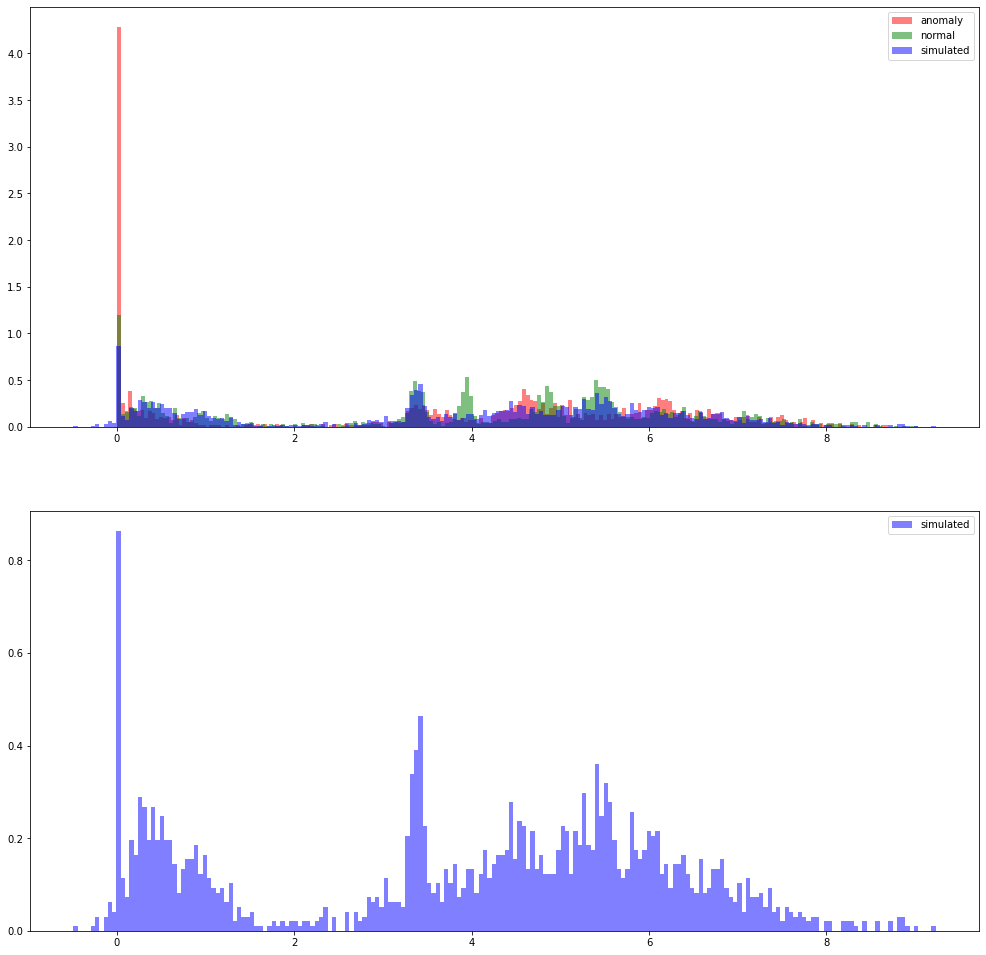

49.1875626352587


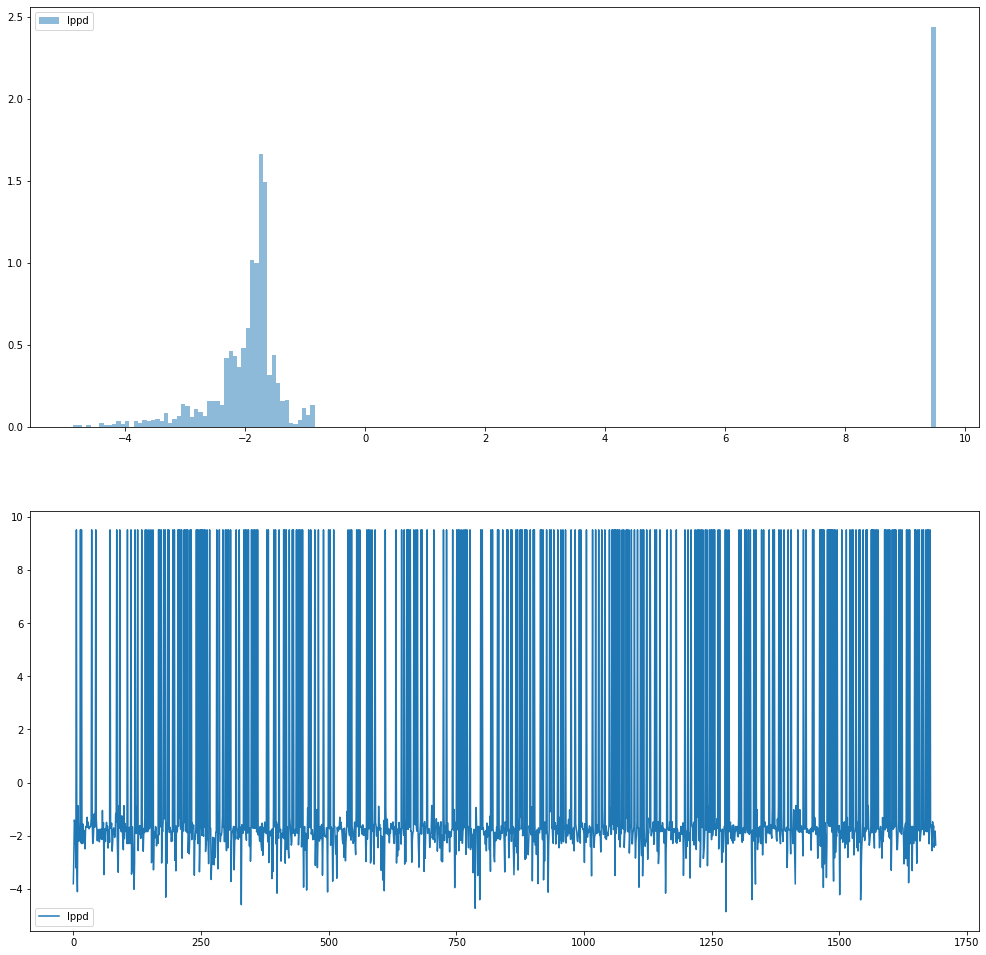

In [56]:
mu, sigma, theta = train_and_plot(5, stan_normal_data, stan_anomaly_data)
sim, lppds = simulation_and_lppd(mu, sigma, theta, stan_normal_data, stan_anomaly_data)

In [57]:
mu, sigma, theta = train_and_plot(5, stan_normal_data, stan_anomaly_data)
all_lppds = []
for offset_size in range(0, len(stan_anomaly_data), 100):
    wlppd, _ = calc_lppd_vec_sliding_window(mu, sigma, theta, stan_anomaly_data[offset_size:offset_size + 100], 5)
    all_lppds.append(wlppd)


(1676,)
Inference for Stan model: anon_model_c96ff13f2c78246360a2ede4a660feb0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      0.12    0.15   0.21 -2.9e-7 -5.9e-8 5.7e-8   0.23   0.52      2  18.48
mu[2]      1.15    0.91   1.29     0.3    0.31   0.46   2.12   3.39      2 364.32
mu[3]      2.92    1.35   1.92    1.02    1.02   2.33   5.04   5.05      2  14.42
mu[4]      4.31    0.67   0.94    3.37    3.38   4.21   5.24   5.46      2  145.0
mu[5]      5.38    0.22   0.36    5.08    5.16   5.28   5.37   6.49      3   2.02
sigma[1]   0.11    0.13   0.19  8.0e-7  9.5e-7 1.5e-6   0.21   0.46      2  20.13
sigma[2]    0.2    0.09   0.12    0.06    0.13   0.18    0.3    0.4      2  39.58
sigma[3]   0.81    0.37   0.53    0.27    0.29   0.55   1.43   1.48      2   6.44
sigma[4]   0.29    0.26   0.37    0.06    0.06   0.07   0.57   0.93

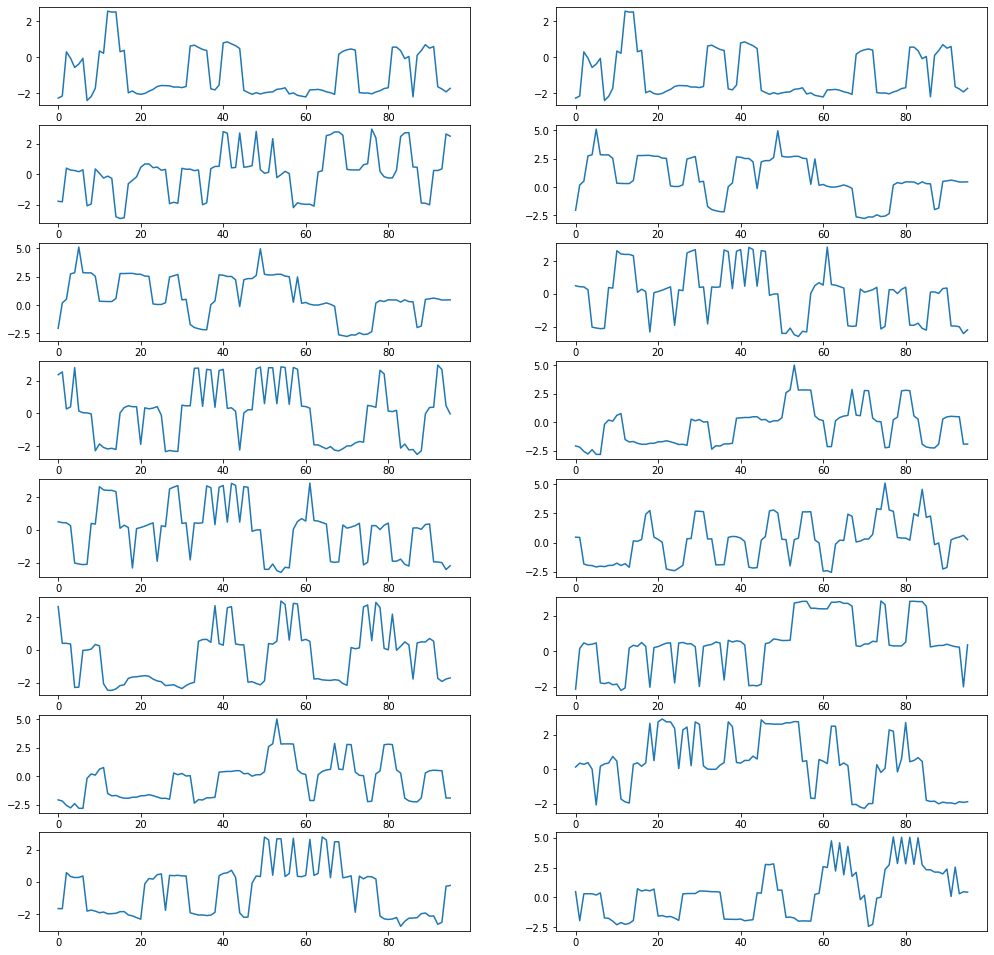

In [58]:
plots_shape = (2,2)
if len(all_lppds) % 3 == 0:
    plots_shape = (int(len(all_lppds)/3), 3)
else:
    plots_shape = (int(len(all_lppds)/2), 2)
fig, axs = plt.subplots(plots_shape[0], plots_shape[1], figsize=(17, 17))
for i in range(plots_shape[0]):
    for j in range(plots_shape[1]):
        axs[i][j].plot(range(len(all_lppds[i * j + i])), all_lppds[i * j + i])
plt.show()

In [59]:
mu, sigma, theta = train_and_plot(5, stan_normal_data, stan_anomaly_data)
all_lppds = []
for offset_size in range(0, len(stan_anomaly_data), 100):
    lppds, lppd = calc_lppd_vec_sliding_window(mu, sigma, theta, 
                                stan_normal_data[offset_size:offset_size + 100])
    all_lppds.append(lppds)

(1676,)
Inference for Stan model: anon_model_c96ff13f2c78246360a2ede4a660feb0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      0.12    0.15   0.21 -2.9e-7 -5.9e-8 5.7e-8   0.23   0.52      2  18.48
mu[2]      1.15    0.91   1.29     0.3    0.31   0.46   2.12   3.39      2 364.32
mu[3]      2.92    1.35   1.92    1.02    1.02   2.33   5.04   5.05      2  14.42
mu[4]      4.31    0.67   0.94    3.37    3.38   4.21   5.24   5.46      2  145.0
mu[5]      5.38    0.22   0.36    5.08    5.16   5.28   5.37   6.49      3   2.02
sigma[1]   0.11    0.13   0.19  8.0e-7  9.5e-7 1.5e-6   0.21   0.46      2  20.13
sigma[2]    0.2    0.09   0.12    0.06    0.13   0.18    0.3    0.4      2  39.58
sigma[3]   0.81    0.37   0.53    0.27    0.29   0.55   1.43   1.48      2   6.44
sigma[4]   0.29    0.26   0.37    0.06    0.06   0.07   0.57   0.93

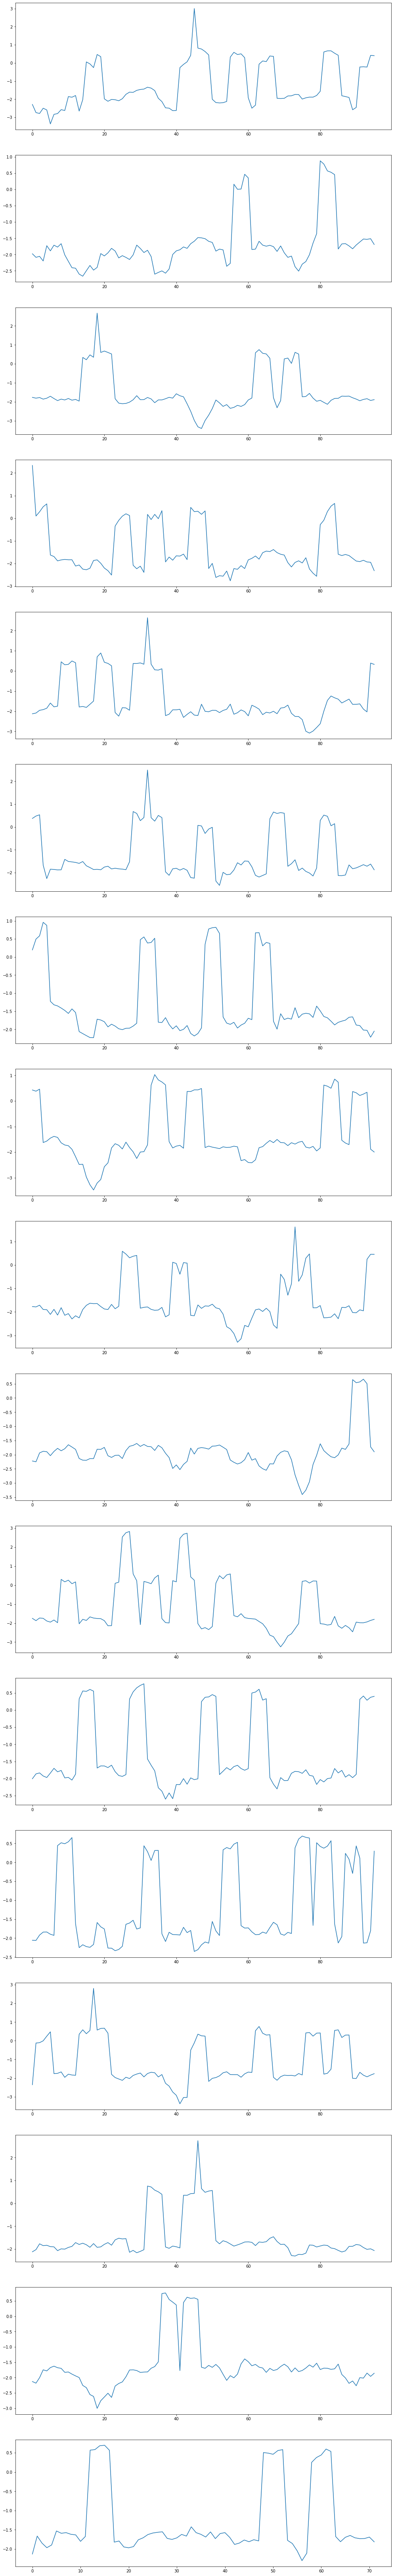

In [60]:
fig, axs = plt.subplots(int(len(all_lppds)), figsize=(17, 7*len(all_lppds)))
for i in range(int(len(all_lppds))):
    axs[i].plot(range(len(all_lppds[i])), all_lppds[i])
plt.show()

In [61]:
mu, sigma, theta = train_and_plot(5, stan_normal_data, stan_anomaly_data)
all_norm_lppds, lppd = calc_lppd_vec_sliding_window(mu, sigma, theta, stan_normal_data, 5)
all_anomaly_lppds, anom_lppd = calc_lppd_vec_sliding_window(mu, sigma, theta, stan_anomaly_data, 5)

(1676,)
Inference for Stan model: anon_model_c96ff13f2c78246360a2ede4a660feb0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      0.12    0.15   0.21 -2.9e-7 -5.9e-8 5.7e-8   0.23   0.52      2  18.48
mu[2]      1.15    0.91   1.29     0.3    0.31   0.46   2.12   3.39      2 364.32
mu[3]      2.92    1.35   1.92    1.02    1.02   2.33   5.04   5.05      2  14.42
mu[4]      4.31    0.67   0.94    3.37    3.38   4.21   5.24   5.46      2  145.0
mu[5]      5.38    0.22   0.36    5.08    5.16   5.28   5.37   6.49      3   2.02
sigma[1]   0.11    0.13   0.19  8.0e-7  9.5e-7 1.5e-6   0.21   0.46      2  20.13
sigma[2]    0.2    0.09   0.12    0.06    0.13   0.18    0.3    0.4      2  39.58
sigma[3]   0.81    0.37   0.53    0.27    0.29   0.55   1.43   1.48      2   6.44
sigma[4]   0.29    0.26   0.37    0.06    0.06   0.07   0.57   0.93

Text(0.5, 1.0, 'LPPDs')

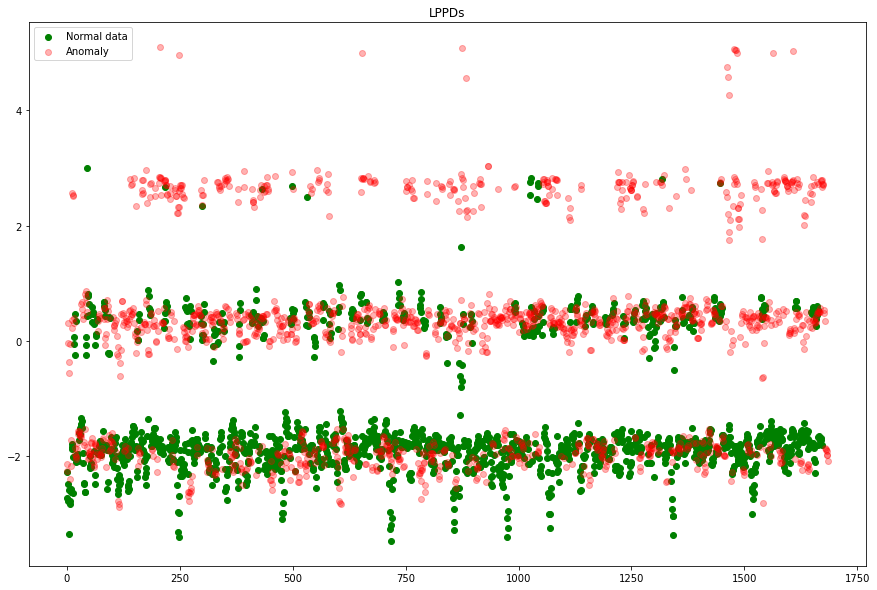

In [62]:
fig, axs = plt.subplots(1, figsize=(15, 10))
emptyData = [None] * (len(all_norm_lppds)-len(all_anomaly_lppds))
all_anomaly_lppds += emptyData
axs.scatter(range(len(all_norm_lppds)), all_norm_lppds, color="g", label="Normal data")
axs.scatter(range(len(all_anomaly_lppds)), all_anomaly_lppds, color="r",alpha=0.3, label="Anomaly")
axs.legend()
axs.set_title('LPPDs')

In [63]:
from sklearn.manifold import TSNE

In [83]:
tnse = TSNE(n_components=2, init='random')
X_embedded = tnse.fit_transform(norm_data)
print(X_embedded.shape)

(1676, 2)


In [84]:
X_anom = tnse.fit_transform(anomaly_norm_data)

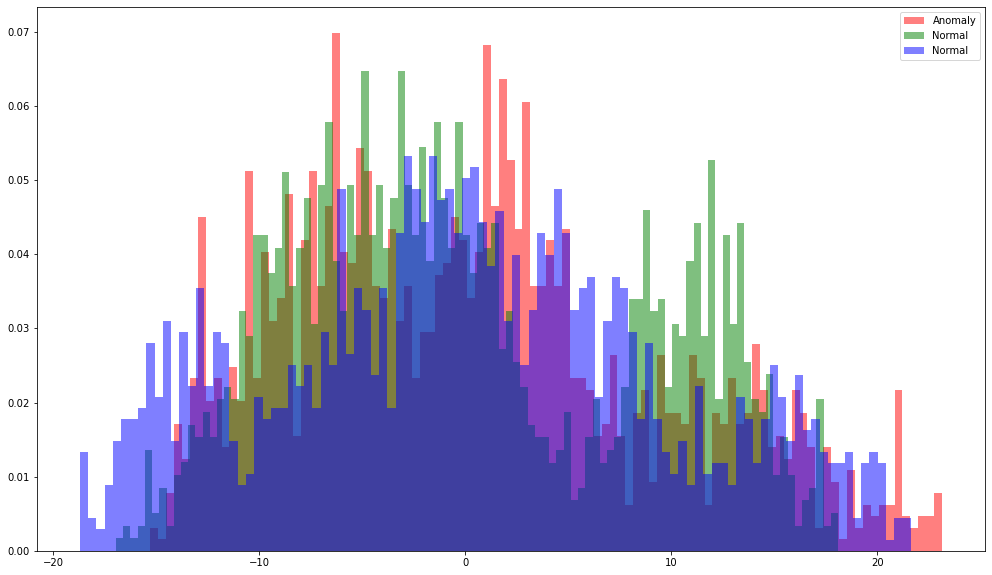

In [81]:
fig, axs = plt.subplots(1, figsize=(17, 10))
n, anomaly_bins, patches = axs.hist(X_embedded[:,0], 100, facecolor='r', alpha=0.5, density=True, stacked=True, label="Anomaly")
n, norm_bins, patches = axs.hist(X_embedded[:,1], 100, facecolor='g', alpha=0.5, density=True, stacked=True, label="Normal")
n, norm_bins, patches = axs.hist(X_embedded[:,2], 100, facecolor='b', alpha=0.5, density=True, stacked=True, label="Normal")
axs.legend()


In [118]:
MILTI_DIM_GMM_MODEL = """
data {
    int<lower=1> D;            // Dimentions
    int<lower=0> N;            // Number of measurements
    vector[D] y[N];            // Data
    
    int<lower=1> k;// Number of Gaussians

}
parameters {
    vector[D] mu[k];
    vector<lower=0.0>[D] sigma[k];
    simplex[k] theta;
}
model {
    real ll[k];
    
    for (n in 1:N) {
        for (m in 1:k) {
            ll[m] <- log(theta[m]);
            for (d in 1:D) {
                ll[m] <- ll[m] + normal_log(y[n, d], mu[m, d], sigma[m, d]);
            }
        }
        target += log_sum_exp(ll);
    }       
}
"""

In [119]:
model = None
if os.path.isfile('./stan/model_multigmm.pkl'):
    model = pickle.load(open('./stan/model_multigmm.pkl', 'rb'))
else:  
    model = pystan.StanModel(model_code=MILTI_DIM_GMM_MODEL, verbose=False, extra_compile_args=["-w"])
    with open('./stan/model_multigmm.pkl', 'wb') as f:
        pickle.dump(model, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_08e1c9a3e21e50322d00591c61dc7733 NOW.


In [111]:
def train_multi_gmm(num_of_gaussians, data):
    print(data.shape)
    st_data= {
        'N':data.shape[0],
        'D': data.shape[1],
        'y': data,
        'k': num_of_gaussians
    }
    fit = None
    if os.path.isfile('./stan/multi_fit_' + DATASET_NAME+ '_' + str(num_of_gaussians) + '.pkl'):
        fit = pickle.load(open('./stan/multi_fit_' + DATASET_NAME + '_' + str(num_of_gaussians) + '.pkl', 'rb'))
    else:
        fit = model.sampling(data=st_data, iter=1000, verbose=False, n_jobs=-1)
        with open('./stan/multi_fit_' + DATASET_NAME + '_' + str(num_of_gaussians) + '.pkl', 'wb') as g:
            pickle.dump(fit, g)
    
    print(fit)
    samples = fit.extract(permuted=True)
    mu = samples['mu']
    sigma = samples['sigma']
    theta = samples['theta']
    print(np.mean(mu, axis=0))
    print(np.mean(sigma, axis=0))
    print(np.mean(theta, axis=0))
    
    return mu, sigma, theta
    

In [120]:
mu, sigma, theta = train_multi_gmm(2, norm_data)

(1676, 249)


/Users/igorvinokur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  from ipykernel import kernelapp as app
/Users/igorvinokur/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/igorvinokur/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/igorvinokur/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:211: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Inference for Stan model: anon_model_08e1c9a3e21e50322d00591c61dc7733.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
mu[1,1]         3.67    3.74    5.29     0.2    0.48    0.83     7.4   12.84      2 1060.6
mu[2,1]        -0.16    0.69    0.98   -1.23   -1.15   -0.12    0.83    0.84      2 3174.8
mu[1,2]         -0.5    0.54    0.76   -1.61   -1.08   -0.49    0.09    0.56      2  95.41
mu[2,2]        -0.09    0.56    0.79   -0.66   -0.59   -0.49    0.49    1.28      2 2192.9
mu[1,3]        -2.43    1.95    2.76   -7.21   -4.41    -1.0   -0.74   -0.53      2 2044.1
mu[2,3]        -0.53    0.56     0.8    -1.0   -0.99   -0.98    0.03    0.85      2 1751.7
mu[1,4]        -2.19    2.39    3.39   -8.06   -4.57   -0.26   -0.21    -0.2      2 3873.5
mu[2,4]        -0.19    0.25    0.35   -0.67   -0.46    -0.2    0.08    0.31      2 1

In [121]:
print(mu)

[[[  0.19637203   0.55595228  -0.5298665  ...   0.04893893   0.54708093
     0.36129253]
  [  0.83890685  -0.49387904  -0.99999953 ...   0.25425533  -0.31196274
     0.57712923]]

 [[  0.19636638   0.55561812  -0.53008092 ...   0.04852548   0.54747738
     0.36150317]
  [  0.83867378  -0.49404634  -1.00000013 ...   0.25415094  -0.31226916
     0.57688262]]

 [[  0.19638849   0.55576224  -0.53010332 ...   0.04866488   0.54739454
     0.36132055]
  [  0.83876194  -0.4940078   -1.00000012 ...   0.25417622  -0.31227616
     0.57673957]]

 ...

 [[ 12.80598787  -1.58796492  -7.20623153 ...   7.53995188  -6.28177538
   -14.91013659]
  [  0.81008541  -0.48233389  -0.98599556 ...   0.23016472  -0.30854821
     0.57291349]]

 [[ 12.81578565  -1.59035395  -7.20283752 ...   7.5416687   -6.2760047
   -14.91009512]
  [  0.8108109   -0.48271789  -0.98713056 ...   0.22985561  -0.30785095
     0.5727571 ]]

 [[ 12.80096445  -1.59644979  -7.20612577 ...   7.5414997   -6.27834687
   -14.91131086]
  [  0

In [122]:
print(sigma)

[[[8.84279788e-001 7.29008993e-001 5.78619253e-001 ... 3.62381165e-001
   2.03719848e+000 2.60551842e-001]
  [1.09823785e-001 1.92488712e-001 9.19227141e-006 ... 2.83810606e-001
   1.68100295e-001 2.13503722e-001]]

 [[8.84208605e-001 7.29151932e-001 5.78403967e-001 ... 3.62448039e-001
   2.03692245e+000 2.60461261e-001]
  [1.09811804e-001 1.92438141e-001 9.36433220e-006 ... 2.83852459e-001
   1.68096240e-001 2.13539727e-001]]

 [[8.84255455e-001 7.29064465e-001 5.78451928e-001 ... 3.62451980e-001
   2.03732688e+000 2.60492451e-001]
  [1.09828868e-001 1.92436135e-001 9.36121090e-006 ... 2.83823966e-001
   1.68108346e-001 2.13539455e-001]]

 ...

 [[1.60955802e+079 4.38407550e+039 1.36634230e+102 ... 2.42156259e+088
   4.73182111e+059 6.83818728e+067]
  [1.78981331e-001 2.01825544e-001 1.77975951e-001 ... 2.86617658e-001
   1.64596591e-001 2.17859487e-001]]

 [[1.91861728e+079 4.52429201e+039 1.16641924e+102 ... 3.69638886e+088
   4.99464320e+059 7.82157402e+067]
  [1.78760544e-001 2.01

In [123]:
print(theta)

[[0.09444134 0.90555866]
 [0.09444763 0.90555237]
 [0.09445655 0.90554345]
 ...
 [0.00105265 0.99894735]
 [0.00105245 0.99894755]
 [0.00105248 0.99894752]]
